**[ODE-01]** 必要なモジュールをインポートして、乱数のシードを設定します。

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

np.random.seed(20160703)
tf.set_random_seed(20160703)

**[ODE-02]** データファイル「ORENIST.data」から画像とラベルのデータを読み込みます。Python3に対応する変換済みファイルを利用。

In [2]:
# Python 2.7
#with open('ORENIST.data', 'rb') as file:
# changed to Python 3.6
with open('ORENIST3p2b.data', 'rb') as file:
    images, labels = pickle.load(file,  encoding='bytes')

**[ODE-03]** 画像データにフィルターとプーリング層を適用する計算式を用意します。

In [3]:
x = tf.placeholder(tf.float32, [None, 784])
x_image = tf.reshape(x, [-1,28,28,1])

W_conv = tf.Variable(tf.truncated_normal([5,5,1,2], stddev=0.1))
h_conv = tf.abs(tf.nn.conv2d(x_image, W_conv,
                             strides=[1,1,1,1], padding='SAME'))
h_conv_cutoff = tf.nn.relu(h_conv-0.2)

h_pool =tf.nn.max_pool(h_conv_cutoff, ksize=[1,2,2,1],
                       strides=[1,2,2,1], padding='SAME')

**[ODE-04]** プーリング層からの出力を全結合層とソフトマックス関数からなる「拡張された出力層」に入力する計算式を用意します。

In [4]:
h_pool_flat = tf.reshape(h_pool, [-1, 392])

num_units1 = 392
num_units2 = 2

w2 = tf.Variable(tf.truncated_normal([num_units1, num_units2]))
b2 = tf.Variable(tf.zeros([num_units2]))
hidden2 = tf.nn.tanh(tf.matmul(h_pool_flat, w2) + b2)

w0 = tf.Variable(tf.zeros([num_units2, 3]))
b0 = tf.Variable(tf.zeros([3]))
p = tf.nn.softmax(tf.matmul(hidden2, w0) + b0)

**[ODE-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [5]:
t = tf.placeholder(tf.float32, [None, 3])
loss = -tf.reduce_sum(t * tf.log(p))
train_step = tf.train.AdamOptimizer().minimize(loss)
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

**[ODE-06]** セッションを用意して、Variable を初期化します。

In [6]:
### >>> with GPU 80%
#gpuConfig = tf.ConfigProto(
#    gpu_options = tf.GPUOptions(
#        per_process_gpu_memory_fraction = 0.8),
#    device_count = {'GPU':0})
#sess = tf.Session(config = gpuConfig)
### <<<
#
### >>> with CPU only
sess = tf.Session()
### <<<
sess.run(tf.global_variables_initializer())
### 下記はPython3.6ではエラーとなるので、上記に変更した。
#sess.run(tf.initialize_all_variables())

**[ODE-07]** パラメーターの最適化を200回繰り返します。

In [7]:
i = 0
for _ in range(200):
    i += 1
    sess.run(train_step, feed_dict={x:images, t:labels})
    if i % 10 == 0:
        loss_val, acc_val = sess.run(
            [loss, accuracy], feed_dict={x:images, t:labels})
        print ('Step: %d, Loss: %f, Accuracy: %f'
               % (i, loss_val, acc_val))

Step: 10, Loss: 98.618576, Accuracy: 0.644444
Step: 20, Loss: 98.038155, Accuracy: 0.677778
Step: 30, Loss: 97.233795, Accuracy: 0.711111
Step: 40, Loss: 96.180771, Accuracy: 0.811111
Step: 50, Loss: 94.908409, Accuracy: 0.844444
Step: 60, Loss: 93.200798, Accuracy: 0.877778
Step: 70, Loss: 90.980301, Accuracy: 0.922222
Step: 80, Loss: 88.383949, Accuracy: 0.955556
Step: 90, Loss: 85.740112, Accuracy: 0.955556
Step: 100, Loss: 83.204849, Accuracy: 0.977778
Step: 110, Loss: 80.816383, Accuracy: 0.988889
Step: 120, Loss: 78.658554, Accuracy: 1.000000
Step: 130, Loss: 76.669159, Accuracy: 1.000000
Step: 140, Loss: 74.855209, Accuracy: 1.000000
Step: 150, Loss: 73.187653, Accuracy: 1.000000
Step: 160, Loss: 71.617470, Accuracy: 1.000000
Step: 170, Loss: 70.126656, Accuracy: 1.000000
Step: 180, Loss: 68.702347, Accuracy: 1.000000
Step: 190, Loss: 67.336197, Accuracy: 1.000000
Step: 200, Loss: 66.022049, Accuracy: 1.000000


**[ODE-08]** 最適化後の畳込みフィルターの値と、最初の9個分の画像データに対して、畳み込みフィルターとプーリング層を適用した結果を取得します。

In [8]:
filter_vals, conv_vals, pool_vals = sess.run(
    [W_conv, h_conv_cutoff, h_pool], feed_dict={x:images[:9]})

**[ODE-09]** 畳込みフィルターを適用した結果を画像として表示します。

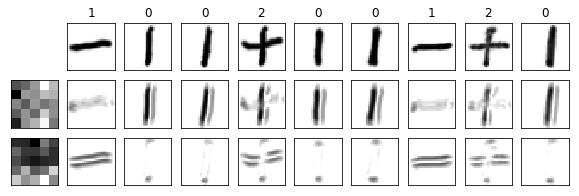

In [9]:
fig = plt.figure(figsize=(10,3))

v_max = np.max(conv_vals)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,0], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')

**[ODE-10]** 畳込みフィルターとプーリング層を適用した結果を画像として表示します。

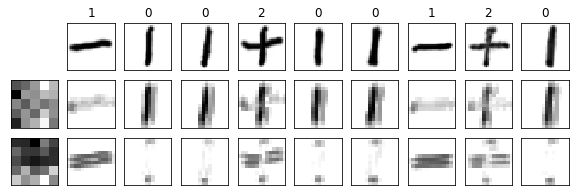

In [10]:
fig = plt.figure(figsize=(10,3))

v_max = np.max(pool_vals)

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:,:,0,i],
                   cmap=plt.cm.gray_r, interpolation='nearest')

for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title('%d' % np.argmax(labels[i]))
    subplot.imshow(images[i].reshape((28,28)), vmin=0, vmax=1,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,0], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_vals[i,:,:,1], vmin=0, vmax=v_max,
                   cmap=plt.cm.gray_r, interpolation='nearest')